In [96]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data processing

In [97]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import warnings

torch.manual_seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"

print ('device =', device)

warnings.filterwarnings("ignore", category=UserWarning)  # Suppress warnings

AttributeError: 'str' object has no attribute 'is_cuda'

## import data - CIFAR10

In [ ]:
# transformations on the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# import the data
train_data = datasets.CIFAR10(root='kaggle/input/', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='kaggle/input/', train=False, download=True, transform=transform)

#train_data = datasets.CIFAR10(root='kaggle/input/', train=True, download=True)
#test_data = datasets.CIFAR10(root='kaggle/input/', train=False, download=True)


In [ ]:
# checking the images
total_train = len(train_data)
total_test = len(test_data)
print ('Total images in train dataset = ', total_train)
print ('Total images in test dataset = ', total_test)

fig, axs = plt.subplots(8, 8, figsize = (9, 9))

for i in range(8):
    for j in range(8):
        index = i*8 + j
        
        if index > total_train:
            break
        else:
            image, label = train_data[index]
            # unnormalize image
            image = (image * 0.5) + 0.5
            
            # turn into numpy array and transpose
            image = np.array(image).transpose((1, 2, 0))
            
            ax = axs[i, j]
            ax.imshow(image)
            ax.axis('off')
            #axs[i, j] = plt.imshow(image)
            #axs[i, j].axis('off')
#plt.tight_layout()
plt.show()


## make DataLoader

In [ ]:
IMG_SIZE = 32
BATCH_SIZE = 2048

# train set data-loader
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

# test set data loader
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

# Make Diffusion Model

## model the forward process

In [ ]:
import torch.nn.functional as F


# function to do 'Linear' Beta scheduling
def beta_schedule(time_steps: int, start: float =1e-4, end: float =0.02) -> List[torch.tensor]:
    '''
    Function to return a tensor list of Linearly scheduled Beta values.
    
    Args:
        time_steps (int): number of time steps in the forward process.
        start (float): start value of Beta.
        end (float): end value of Beta
        
    Returns:
        A tensor list of Linearly scheduled Beta values.
    '''
    return torch.linspace(start, end, time_steps)

# Define beta schedule
# Total time steps
T = 300

betas = beta_schedule(time_steps=T)

# Calculate different closed form formula terms
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

# calculate prev alphas_cumprod
# e.g, if alphas_cumprod = [2.0, 4.0, 12.0]
# then prev_alphas_cumpred = [1.0, 2.0, 4.0]
prev_alphas_cumprod = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)

sqrt_recip_alphas = torch.sqrt(1.0/alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
posterior_variance = betas * (1. - prev_alphas_cumprod) / (1. - alphas_cumprod)

# Function to return particular alphas_cumprod vals from particular timesteps given a timestep vector
def get_timestepped_elem_from_list(list_tensor: torch.tensor, timestep: torch.tensor, x_shape: list) -> List[torch.tensor]:
    '''
    This function returns tensor elements particular to the time-steps as mentioned
    in the timestep vector, keeping the batch size intact.
    
    Args:
        list_tensor (torch.tensor): A tensor list of values.
        timestep (torch.tensor): A tensor list of time steps.
        x_shape (list): python list of shape of a tensor
        
    Returns:
        List[torch.tensor]: Returns tensor elements particular to the time-steps as mentioned
    in the timestep vector, keeping the batch size intact.
    '''
    batch_size = timestep.shape[0]
    out = list_tensor.gather(-1, timestep.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(timestep.device)

# Forward Diffusion sampling
def forward_diffusion_sample(x_0: torch.tensor, timestep: torch.tensor, device="cpu") -> torch.tensor:
    '''
    Function to calculate the noisy version of the image x_0 at time step timestep. It returns q(x_t|x_0).
    
    Args:
        x_0 (torch.tensor): Input initial image at time instant 0.
        timestep (torch.tensor): Tensor list of the time instants for which we need he noisy versions.
        device: Device where to run this function (cpu/gpu).
        
    Returns:
        torch.tensor: Returns q(x_t|x_0).
    '''
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_timestepped_elem_from_list(sqrt_alphas_cumprod, timestep, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_timestepped_elem_from_list(
        sqrt_one_minus_alphas_cumprod, timestep, x_0.shape
    )
    
    # return mean and variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

/tmp/ipykernel_34/3125062421.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/step_size) + 1)


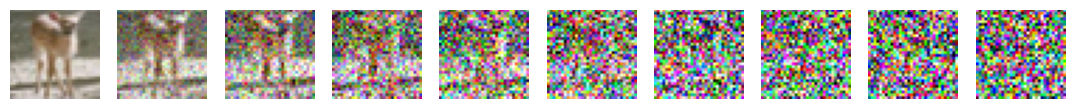

In [98]:
# checking the forward diffusion process
image = next(iter(train_loader))[0][0]

plt.figure(figsize = (15,15))
plt.axis('off')
num_images = 10
step_size = int(T/num_images)

for idx in range(0, T, step_size):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/step_size) + 1)
    img, noise = forward_diffusion_sample(image, t)
    # unnormalize image
    img = (img * 0.5) + 0.5

    # turn into numpy array and transpose
    img = np.array(img).transpose((1, 2, 0))
    
    plt.imshow(img)
    plt.axis('off')


## model the reverse process

In [99]:
from torch import nn
import math

class unet_Block(nn.Module):
    '''
    This class defines the up and down portions of a simple U-Net.
    '''
    def __init__(self, in_channel: int, out_channel: int, time_emb_dim: int, up: bool= False):
        super(unet_Block, self).__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_channel)
        
        if up:
            self.conv1 = nn.Conv2d(in_channel*2, out_channel, kernel_size=3, padding=1)
            self.transform = nn.ConvTranspose2d(out_channel, out_channel, kernel_size=4, stride=2, padding=1)
            
        else:
            self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1)
            self.transform = nn.Conv2d(out_channel, out_channel, kernel_size=4, stride=2, padding=1)
            
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        
    def forward(self, x, time_emb):
        # first conv
        x = self.bn1(self.relu(self.conv1(x)))
        
        # time embedding
        time_emb = self.relu(self.time_mlp(time_emb))
        
        # extend by 2 dims from the last dim of time_emb
        time_emb = time_emb[(...,) + (None,)*2]
        
        # add time channel
        x = x + time_emb
        
        # second conv
        x = self.bn2(self.relu(self.conv2(x)))
        
        # Down or Up sample
        x = self.transform(x)
        
        return x
    
class SinusoidalPositionEmbedding(nn.Module):
    '''
    Class to compute the sinusoidal positional embeddings. 
    '''
    def __init__(self, dim: int):
        super(SinusoidalPositionEmbedding, self).__init__()
        self.dim = dim
        
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        
        return embeddings
        
class Simple_Unet(nn.Module):
    '''
    This is the main U-Net class.
    '''
    def __init__(self):
        super(Simple_Unet, self).__init__()
        
        image_channel = 3
        
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        
        out_channel = 3
        
        time_emb_dim = 32
        
        # time embeddings
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        
        # Initial processing
        self.conv0 = nn.Conv2d(image_channel, down_channels[0], kernel_size=3, padding=1)
        
        # Down-sample
        self.downs = nn.ModuleList([
            unet_Block(down_channels[i], down_channels[i+1], time_emb_dim) \
            for i in range(len(down_channels)-1)
        ])
        
        # Up-sample
        self.ups = nn.ModuleList([
            unet_Block(up_channels[i], up_channels[i+1], time_emb_dim, up = True) \
            for i in range(len(up_channels)-1)
        ])
        
        self.output = nn.Conv2d(up_channels[-1], out_channel, 1)
        
    def forward(self, x, time_step):
        # first conv
        x = self.conv0(x)
        
        # time embedding
        t = self.time_mlp(time_step)
        
        # U-Net
        residual_inputs = []
        
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
            
        for up in self.ups:
            residual_x = residual_inputs.pop()
            
            # add residual_x as additional channels
            x = torch.concat((x, residual_x), dim =1)
            
            x = up(x, t)
            
        return self.output(x)
          
# check the model
model = Simple_Unet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
print (model)   

Num params:  62438883
Simple_Unet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbedding()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): unet_Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): unet_Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddi

# The Loss Metric

In [100]:
def get_loss(model: object, x_0: torch.tensor, time_step: torch.tensor) -> float:
    '''
    Loss function (L1 Norm) between the actual noise samples in that time step and 
    the one predicted predicted by the network (U-Net) from the noisy image in that 
    time step during the reverse process.
    
    Args:
        model (object): This is the Diffusion model object name.
        x_0 (torch.tensor): This is the input image at time=0.
        time_step (torch.tensor): This the time step for which we are evaluating 
        the the loss metric.
        
    Returns:
        Float: Returns the MAE between actual noise samples in that time step and 
        the one predicted predicted by the network (U-Net) from the noisy image in 
        that time step during the reverse process.
    '''
    noisy_x, noise = forward_diffusion_sample(x_0, timestep=time_step, device=device)
    noise_pred = model(noisy_x, time_step)
    return F.l1_loss(noise, noise_pred)

# Sampling

* Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation
* Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [101]:
@torch.no_grad
def sample_timestep(x: torch.tensor, time_step: torch.tensor) -> torch.tensor:
    '''
    This function calls the model to predict the noise in the image at that
    time step and returns the denoised image.
    
    Args:
        x (torch.tensor): noisy image at the given time step.
        time_step (torch.tensor): Given time step.
        
    Returns:
        torch.tensor: Returns the denoised image.
    '''
    betas_t = get_timestepped_elem_from_list(betas, time_step, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_timestepped_elem_from_list(
                                        sqrt_one_minus_alphas_cumprod,
                                        time_step,
                                        x.shape
                                        )
    sqrt_recip_alphas_t = get_timestepped_elem_from_list(
                                        sqrt_recip_alphas, 
                                        time_step, 
                                        x.shape
                                        )
    
    # Call model (current noisy image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, time_step) / sqrt_one_minus_alphas_cumprod_t
    )
    
    posterior_variance_t = get_timestepped_elem_from_list(
                                        posterior_variance, 
                                        time_step, 
                                        x.shape
                                        )
    
    if time_step == 0:
        return model_mean
    
    else:
        noise = torch.randn_like(x)
        return model_mean + (torch.sqrt(posterior_variance_t) * noise)

    
@torch.no_grad
def sample_plot_image():
    '''
    Function to initiate and plot the entire reverse process once. It first samples 
    noise with the same shape as the input image and initates the reverse process.
    
    Args:
        None
        
    Returns:
        None
    '''
    # sample noise
    img = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=device)
    
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    
    num_images = 10
    stepsize = int(T/num_images)
    
    for i in range(0, T)[::-1]: # reverse order
        #time_step = torch.tensor([i], device=device, dtype=torch.long)
        time_step = torch.full((1,), i, device=device, dtype=torch.long)
        
        # get denoised image
        img = sample_timestep(img, time_step)
        
        # This is to maintain the natural range of the distribution
        img_ = torch.clamp(img, -1.0, 1.0)
        
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            
            # unnormalize image
            img_ = (img_ * 0.5) + 0.5

            # turn into numpy array and transpose
            img_ = np.array(torch.squeeze(img_.cpu(), dim=0)).transpose((1, 2, 0))

            plt.imshow(img_)
            plt.axis('off')
    plt.show()


# Training

Found saved model /kaggle/working/model0.pt, trying to load it...
model file /kaggle/working/model0.pt has been loaded, training to continue from epoch - 0
Running epoch 0 ...
Epoch 0 | step 000 Loss: 0.7142002582550049 


/tmp/ipykernel_34/3326675325.py:77: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


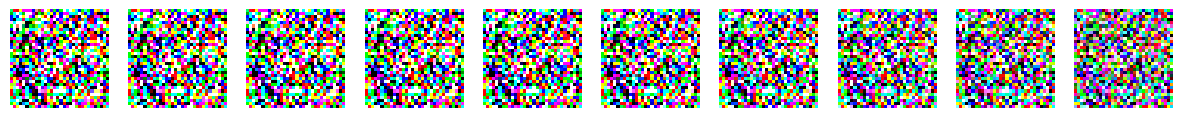

Running epoch 1 ...
Running epoch 2 ...
Running epoch 3 ...
Running epoch 4 ...
Running epoch 5 ...
Running epoch 6 ...
Running epoch 7 ...
Running epoch 8 ...
Running epoch 9 ...
Running epoch 10 ...
Epoch 10 | step 000 Loss: 0.22405800223350525 


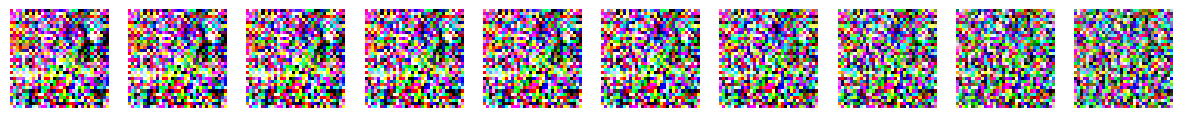

Running epoch 11 ...
Running epoch 12 ...
Running epoch 13 ...
Running epoch 14 ...
Running epoch 15 ...
Running epoch 16 ...
Running epoch 17 ...
Running epoch 18 ...
Running epoch 19 ...
Running epoch 20 ...
Epoch 20 | step 000 Loss: 0.18612584471702576 


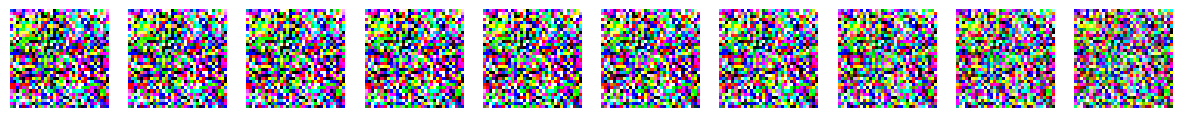

Running epoch 21 ...
Running epoch 22 ...
Running epoch 23 ...
Running epoch 24 ...
Running epoch 25 ...
Running epoch 26 ...
Running epoch 27 ...
Running epoch 28 ...
Running epoch 29 ...
Running epoch 30 ...
Epoch 30 | step 000 Loss: 0.18916484713554382 


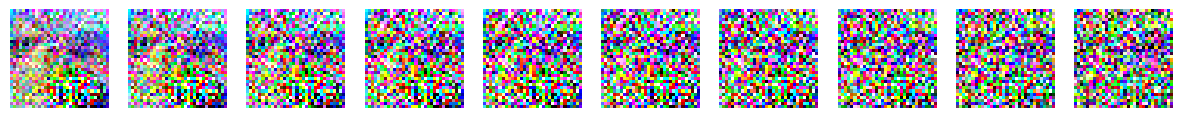

Running epoch 31 ...
Running epoch 32 ...
Running epoch 33 ...
Running epoch 34 ...
Running epoch 35 ...
Running epoch 36 ...
Running epoch 37 ...
Running epoch 38 ...
Running epoch 39 ...
Running epoch 40 ...
Epoch 40 | step 000 Loss: 0.1831706017255783 


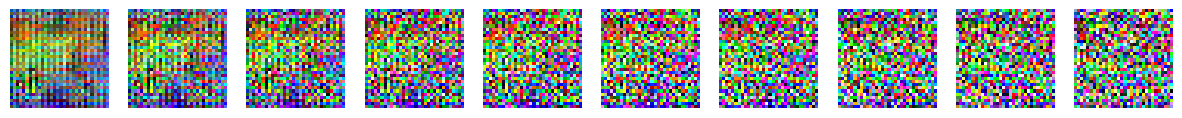

Running epoch 41 ...
Running epoch 42 ...
Running epoch 43 ...
Running epoch 44 ...
Running epoch 45 ...
Running epoch 46 ...
Running epoch 47 ...
Running epoch 48 ...
Running epoch 49 ...
Running epoch 50 ...
Epoch 50 | step 000 Loss: 0.1771656721830368 


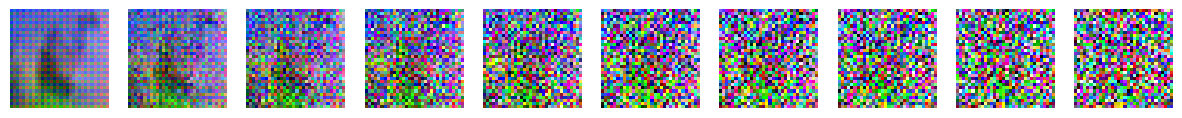

Running epoch 51 ...
Running epoch 52 ...
Running epoch 53 ...
Running epoch 54 ...
Running epoch 55 ...
Running epoch 56 ...
Running epoch 57 ...
Running epoch 58 ...
Running epoch 59 ...
Running epoch 60 ...
Epoch 60 | step 000 Loss: 0.17737874388694763 


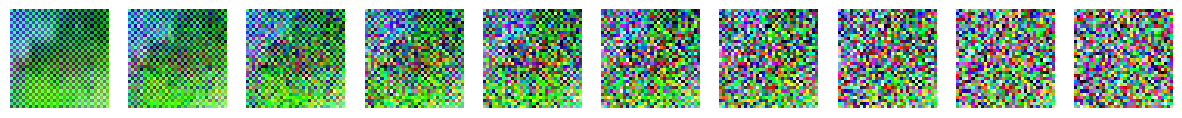

Running epoch 61 ...
Running epoch 62 ...
Running epoch 63 ...
Running epoch 64 ...
Running epoch 65 ...
Running epoch 66 ...
Running epoch 67 ...
Running epoch 68 ...
Running epoch 69 ...
Running epoch 70 ...
Epoch 70 | step 000 Loss: 0.1772104948759079 


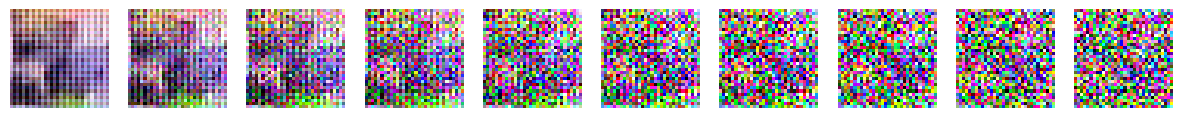

Running epoch 71 ...
Running epoch 72 ...
Running epoch 73 ...
Running epoch 74 ...
Running epoch 75 ...
Running epoch 76 ...
Running epoch 77 ...
Running epoch 78 ...
Running epoch 79 ...
Running epoch 80 ...
Epoch 80 | step 000 Loss: 0.1726406216621399 


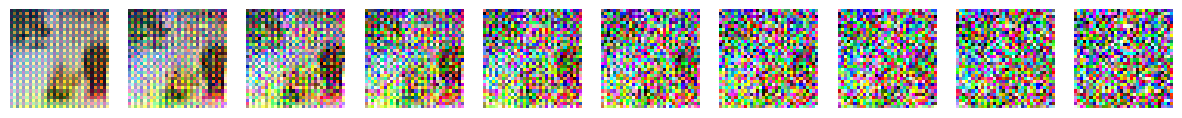

Running epoch 81 ...
Running epoch 82 ...
Running epoch 83 ...
Running epoch 84 ...
Running epoch 85 ...
Running epoch 86 ...
Running epoch 87 ...
Running epoch 88 ...
Running epoch 89 ...
Running epoch 90 ...
Epoch 90 | step 000 Loss: 0.16898155212402344 


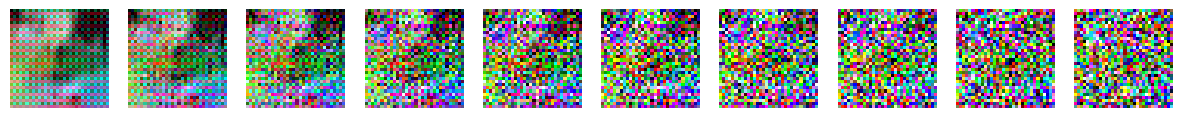

Running epoch 91 ...
Running epoch 92 ...
Running epoch 93 ...
Running epoch 94 ...
Running epoch 95 ...
Running epoch 96 ...
Running epoch 97 ...
Running epoch 98 ...
Running epoch 99 ...
Running epoch 100 ...
Epoch 100 | step 000 Loss: 0.1683211326599121 


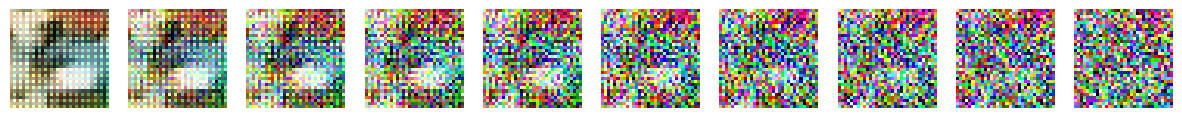

Running epoch 101 ...
Running epoch 102 ...
Running epoch 103 ...
Running epoch 104 ...
Running epoch 105 ...
Running epoch 106 ...
Running epoch 107 ...
Running epoch 108 ...
Running epoch 109 ...
Running epoch 110 ...
Epoch 110 | step 000 Loss: 0.16916108131408691 


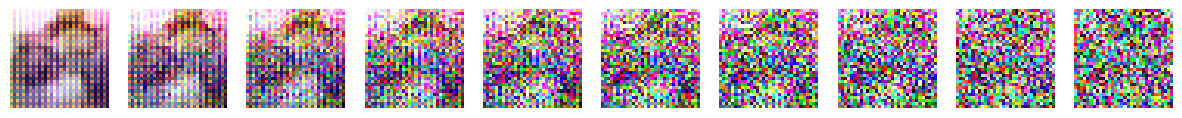

Running epoch 111 ...
Running epoch 112 ...
Running epoch 113 ...
Running epoch 114 ...
Running epoch 115 ...
Running epoch 116 ...
Running epoch 117 ...
Running epoch 118 ...
Running epoch 119 ...
Running epoch 120 ...
Epoch 120 | step 000 Loss: 0.16771891713142395 


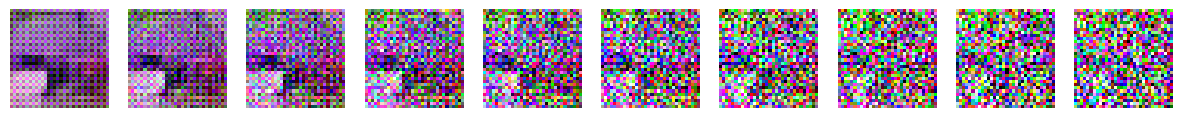

Running epoch 121 ...
Running epoch 122 ...
Running epoch 123 ...
Running epoch 124 ...
Running epoch 125 ...
Running epoch 126 ...
Running epoch 127 ...
Running epoch 128 ...
Running epoch 129 ...
Running epoch 130 ...
Epoch 130 | step 000 Loss: 0.1700444221496582 


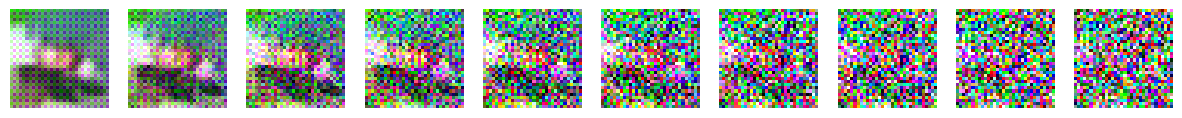

Running epoch 131 ...
Running epoch 132 ...
Running epoch 133 ...
Running epoch 134 ...
Running epoch 135 ...
Running epoch 136 ...
Running epoch 137 ...
Running epoch 138 ...
Running epoch 139 ...
Running epoch 140 ...
Epoch 140 | step 000 Loss: 0.1696041077375412 


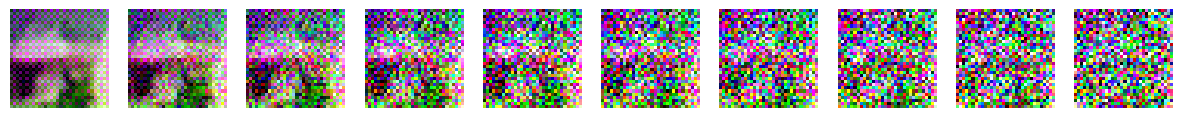

Running epoch 141 ...
Running epoch 142 ...
Running epoch 143 ...
Running epoch 144 ...
Running epoch 145 ...
Running epoch 146 ...
Running epoch 147 ...
Running epoch 148 ...
Running epoch 149 ...


In [103]:
from torch.optim import Adam
import os

optimizer = Adam(model.parameters(), lr=0.001)
EPOCHS = 150
epoch = 0

# store the loss values to plot them
loss_values = []
epoch_values = []

# check if there exists any model checkpoints
saved_paths = ['/kaggle/working/model1.pt', '/kaggle/working/model0.pt']
for path in saved_paths:
    if os.path.exists(path):
        print (f'Found saved model {path}, trying to load it...')
        try:
            checkpoint = torch.load(path, map_location="cuda:0")
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            epoch = checkpoint['epoch']
            loss_values = checkpoint['loss_values']
            epoch_values = checkpoint['epoch_values']
            print (f'model file {path} has been loaded, training to continue from epoch - {epoch}')
            break
        except:
            print (f'model file {path} is corrupt and could not load')
        

model = model.to(device)

# save file number, either 0 or 1
save_num = 0

for epch in range(epoch, EPOCHS):
    for step, batch in enumerate(train_loader):
        if step == 0:
            print (f'Running epoch {epch} ...')
            
        model.train()
        optimizer.zero_grad()
        batch_size = batch[0].shape[0]
        time_step = torch.randint(0, T, (batch_size,), device=device).long()
        
        loss = get_loss(model, batch[0].to(device), time_step)
        loss.backward()
        optimizer.step()
        
        if epch % 5 == 0 and step == 0:
            
            loss_values.append(loss.item())
            epoch_values.append(epch)
            
            torch.save({
            'epoch': epch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            'loss_values': loss_values,
            'epoch_values': epoch_values
            }, f'/kaggle/working/model{save_num}.pt')
            
            save_num = 0 if save_num == 1 else 1
        
        if epch % 10 == 0 and step == 0:
            print(f"Epoch {epch} | step {step:03d} Loss: {loss.item()} ")
            sample_plot_image()